In [ ]:

import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import joblib


Note: you may need to restart the kernel to use updated packages.


In [103]:
df = pd.read_csv("gpu_data.csv")
df.head()



,timestamp,gpu_utilization (%),memory_utilization (%),gpu_power_draw (W),gpu_temperature (°C),gpu_fan_speed (%),gpu_clock_speed (MHz),cpu_utilization (%),memory_usage (%),server_power_draw (W),server_temperature (°C),disk_usage (%),network_bandwidth (Mbps)
0,2025-03-19 22:04:59.495312,88.54,42.96,240.96,83.7,93.54,1674,19.96,80.63,516.39,36.2,25.78,253.88
1,2025-03-19 22:09:59.495312,52.59,62.30,270.16,77.5,82.23,1440,20.11,42.39,258.32,50.2,47.25,517.27
2,2025-03-19 22:14:59.495312,72.84,89.60,290.88,52.2,84.99,1029,23.34,31.54,495.39,40.3,94.95,548.09
3,2025-03-19 22:19:59.495312,44.54,85.03,142.19,59.2,65.90,884,76.70,25.88,466.26,67.7,41.89,381.86
4,2025-03-19 22:24:59.495312,72.15,10.34,200.79,50.7,35.21,961,29.48,50.35,458.42,74.4,31.80,762.41


In [107]:
df = pd.read_csv("gpu_data.csv", parse_dates=['timestamp'], index_col='timestamp')
df = df.asfreq('h')
df.dropna(inplace=True)
df.head()

,gpu_utilization (%),memory_utilization (%),gpu_power_draw (W),gpu_temperature (°C),gpu_fan_speed (%),gpu_clock_speed (MHz),cpu_utilization (%),memory_usage (%),server_power_draw (W),server_temperature (°C),disk_usage (%),network_bandwidth (Mbps)
timestamp,,,,,,,,,,,,
2025-03-19 22:04:59.495312,88.54,42.96,240.96,83.7,93.54,1674,19.96,80.63,516.39,36.2,25.78,253.88
2025-03-19 23:04:59.495312,45.31,68.14,189.87,77.5,34.18,1176,48.56,40.30,372.27,61.9,72.30,89.63
2025-03-20 00:04:59.495312,74.03,19.96,290.30,72.3,53.76,1630,45.14,56.25,282.58,58.7,88.71,207.68
2025-03-20 01:04:59.495312,38.10,65.42,184.74,57.2,36.49,1293,88.08,71.00,568.06,64.9,37.35,680.58
2025-03-20 02:04:59.495312,34.62,13.67,140.44,57.2,46.56,1740,33.08,36.69,437.28,55.4,71.94,887.29


In [120]:
gpu_utilization = df[['gpu_utilization (%)']]
gpu_power_draw = df[['gpu_power_draw (W)']]
gpu_temperature = df[['gpu_temperature (°C)']]


In [110]:
train_size = int(len(gpu_utilization) * 0.8)
train, test = gpu_utilization[:train_size], gpu_utilization[train_size:]

In [111]:
train.reset_index(inplace=True)
train.columns = ['ds', 'y']
test.reset_index(inplace=True)
test.columns = ['ds', 'y']

18:26:39 - cmdstanpy - INFO - Chain [1] start processing
18:26:39 - cmdstanpy - INFO - Chain [1] done processing


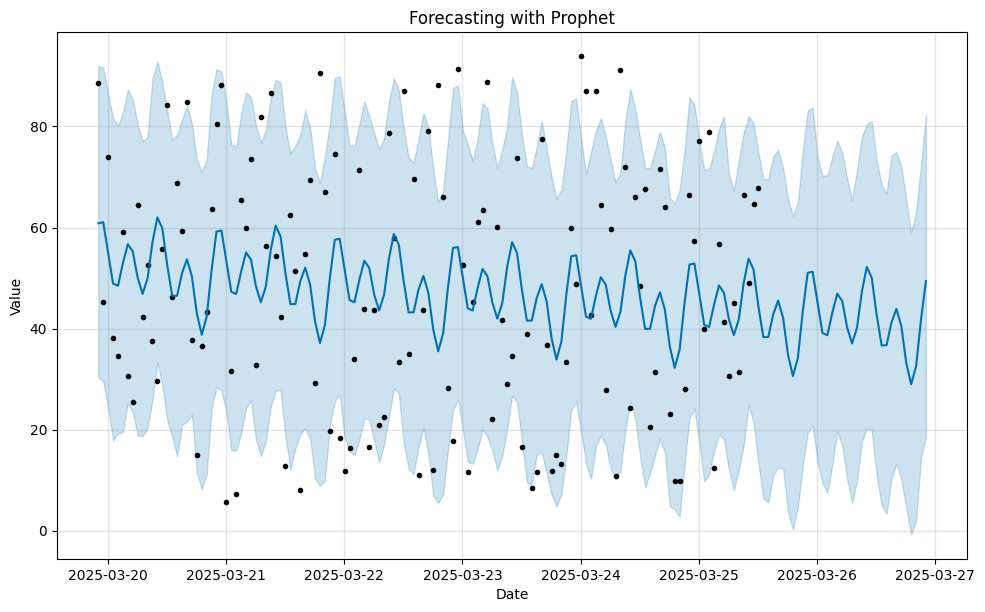

In [117]:
model = Prophet()

model.fit(train)

future = model.make_future_dataframe(periods=len(test), freq='h')
forecast = model.predict(future)

model.plot(forecast)
plt.title("Forecasting with Prophet")
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [ ]:

df_prophet = df.reset_index()
df_prophet = df_prophet.rename(columns={'timestamp': 'ds', 'gpu_utilization (%)': 'y'})
if 'gpu_power_draw (W)' in df.columns:
    df_prophet['gpu_power_draw'] = df['gpu_power_draw (W)']
if 'gpu_temperature (°C)' in df.columns:
    df_prophet['temperature'] = df['gpu_temperature (°C)']
if 'memory_utilization (%)' in df.columns:
    df_prophet['memory_utilization'] = df['memory_utilization (%)']

train_size = int(len(df_prophet) * 0.8)
train, test = df_prophet[:train_size], df_prophet[train_size:]

model = Prophet(
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=10
)

if 'gpu_power_draw' in df_prophet.columns:
    model.add_regressor('gpu_power_draw')
if 'temperature' in df_prophet.columns:
    model.add_regressor('temperature')
if 'memory_utilization' in df_prophet.columns:
    model.add_regressor('memory_utilization')

model.fit(train)


joblib.dump({'model': model}, 'modelo_regressors.pkl')

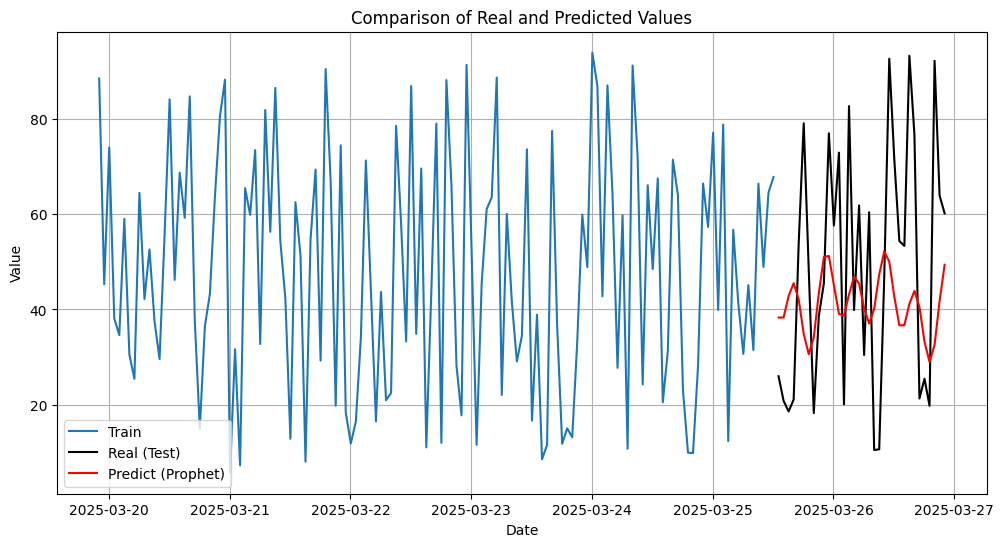

In [118]:
comparison = forecast[['ds', 'yhat']].merge(test, on='ds', how='right')
plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Real (Test)', color='black')
plt.plot(comparison['ds'], comparison['yhat'], label='Predict (Prophet)', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of Real and Predicted Values')
plt.grid(True)
plt.show()

In [ ]:
def predict_from_last_hour(csv_path: str) -> float:
    return None

print(predict_from_last_hour("gpu_data.csv"))
